In [3]:
import numpy as np
import os
import sys
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)
display(d)
from simulation import heart_rate
#%matplotlib widget
from matplotlib import pyplot as plt
from scipy import signal as ss
import scipy
from utils.wall_processing import distance_processing
from simulation.utils import periodic_wrap_fn, SPEED_OF_US, demodulate_I_Q
import utils.signal as sp

plt.style.use('seaborn-whitegrid')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


'/Users/josquintille/Documents/ETHZ/Ultrasound'

In [4]:
ACQ_SYS = "WULPUS"
def get_raw(file_name):
    
    data_file = np.load(file_name)
    if ACQ_SYS == "WULPUS":
        return data_file['data_arr'][:,:]
    else:
        return data_file


0.38555194805194803

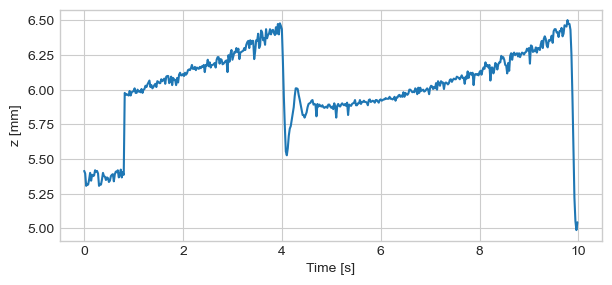

In [10]:
data = get_raw("Doppler_data/sawtooth.npz")
pulse, _ = distance_processing(data)
meas_period= 20_000 / 1E6
t = np.arange(0,len(pulse)*meas_period,meas_period)

plt.figure(figsize=(7,3))
plt.plot(t,np.array(pulse[:]), label="measured")
plt.xlabel("Time [s]")
plt.ylabel("z [mm]")
#plt.xlim((1,4))
plt.grid(True)
plt.savefig("saw_tooth_wall.pdf")
t1,t2 = 1,4
i1 = np.searchsorted(t,t1)
i2 = np.searchsorted(t,t2)
v = (pulse[i2]-pulse[i1])/(t2-t1)/1e3
fd_expected = 2*v/SPEED_OF_US*2e6
fd_expected

In [11]:
IQ_hilbert = ss.hilbert(IQ,axis=1)
forward_backward = IQ_hilbert


(-1.0, 1.0)

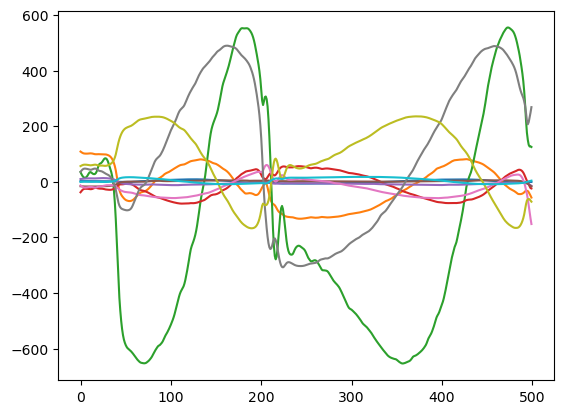

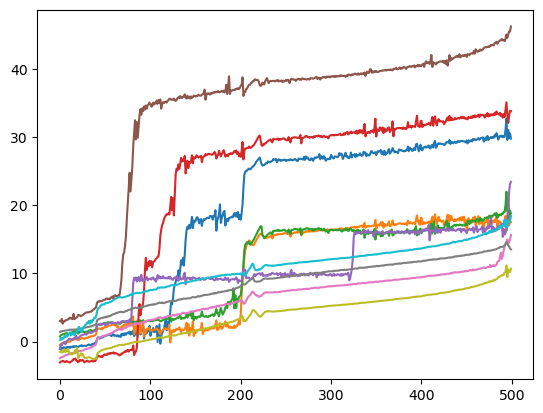

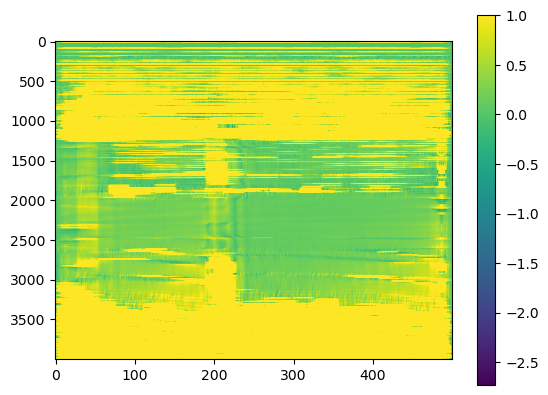

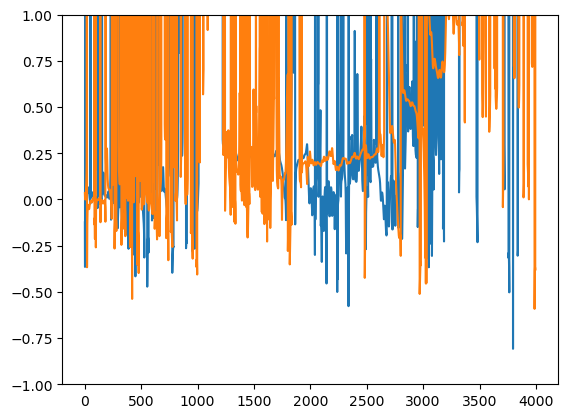

In [12]:
Wn = 2*2/50
b, a = ss.butter(1, Wn, 'low')
IQ_filt = ss.filtfilt(b,a,IQ,axis=1)
for i in np.linspace(1300,2500,10):
    plt.plot(IQ_filt[1,:,int(i)])

IQ_hilbert = ss.hilbert(IQ,axis=1)
forward_backward = np.real(IQ_hilbert)+np.imag(IQ_hilbert[[1,0],:,:])

analytic_signals = ss.hilbert(forward_backward,axis=1)

instantaneous_phases = np.unwrap(np.angle(analytic_signals),axis=1)
plt.figure()
for i in np.linspace(1300,2500,10):
    plt.plot(instantaneous_phases[1,:,int(i)])

    
dif_ker = np.array([1,*([0]*25),-1])

instantaneous_frequencies = scipy.ndimage.convolve1d(instantaneous_phases, dif_ker, axis=1) /  (2.0*np.pi) * 50/(len(dif_ker)-1)
plt.figure()

plt.imshow(instantaneous_frequencies[1,:,:].T,aspect=1/10,vmax=1)

plt.colorbar()
plt.figure()
plt.plot(instantaneous_frequencies[0,150,:])
plt.plot(instantaneous_frequencies[1,150,:])
plt.ylim((-1,1))

# cleaned code


1808560.0

0

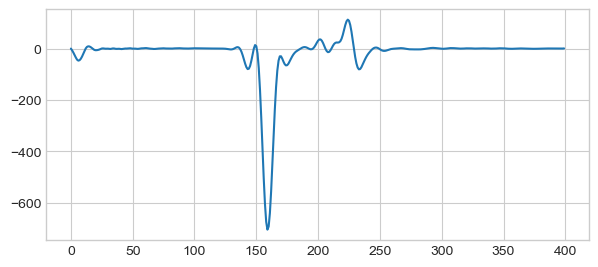

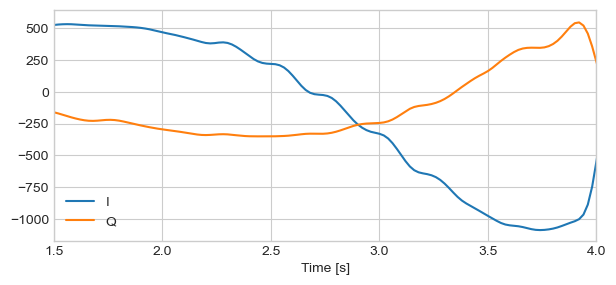

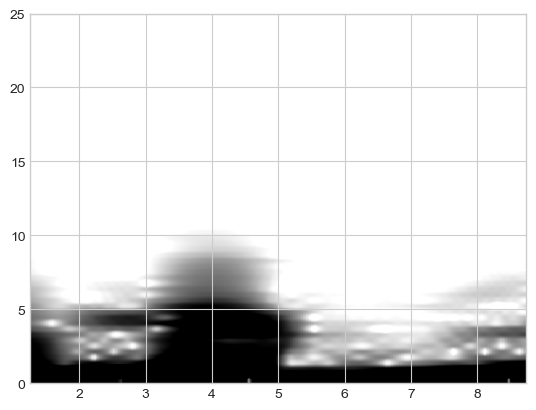

In [17]:
data_filt = sp.remez_bp(data, fc=(1.2e6,2.5e6), fs=8e6, axis = 0)
#plt.magnitude_spectrum(data_filt[:,6],Fs=8e6)
#plt.grid(which='both',axis='both')
#plt.xlim(1.5e6,2.25e6
peak_freq = sp.peak_freq(data_filt,fs=8e6,axis=0)
excitation_freq = peak_freq.mean()
display(excitation_freq)
#display(peak_freq.std())
#plt.hist(peak_freq)
#data_filt = ss.resample(data_filt, data_filt.shape[0]*10)
I,Q = sp.demodulate_I_Q(data_filt,1808560, 1.25e6, dt=1/8e6, filt_order=2, axis=0)
I=sp.butter_lp(data_filt, 5, 50,axis=1)
Q=sp.butter_lp(Q, 5, 50,axis=1)
plt.figure(figsize=(7,3))
plt.plot(Q[:,0])
plt.figure(figsize=(7,3))
plt.plot(t,I[150,:], label='I')
plt.plot(t,Q[150,:], label='Q')
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(1.5,4)
#plt.savefig("doppler_wall.pdf")
plt.figure()
plt.specgram(I[150,:],Fs=50,NFFT=128,noverlap=126,vmin=0,vmax=30)
0
#demod = mult_along_axis(signal,analytic_osc, axis=axis)


#### forward / backward

In [11]:
I_hilbert = ss.hilbert(I,axis=0)
Q_hilbert = ss.hilbert(Q,axis=0)
forward = I_hilbert.real+Q_hilbert.imag
backward = Q_hilbert.real+I_hilbert.imag
plt.plot(forward[250])
plt.plot(backward[250])

NameError: name 'I' is not defined

### Frequency by phase derivative

0

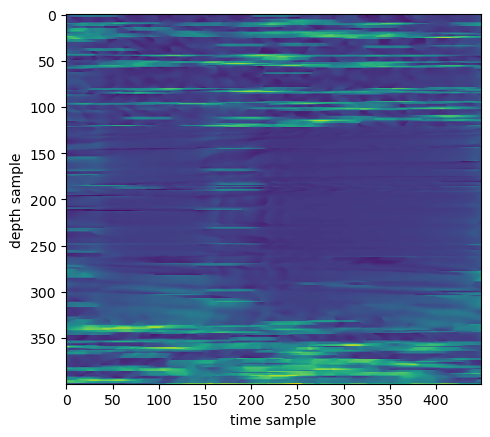

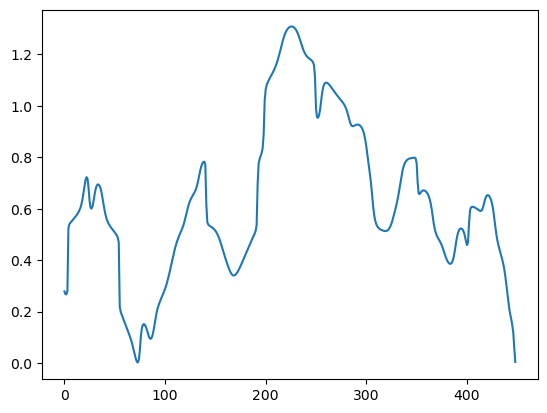

In [23]:
Q_filt = sp.butter_bp(Q,fc=(.1,3),fs=50, order=4)
#plt.plot(Q_filt[150,:])

analytic_signal = ss.hilbert(Q_filt)
amplitude_envelope = np.abs(analytic_signal)
#plt.plot(amplitude_envelope[150,:])

instantaneous_phase = np.unwrap(np.angle(analytic_signal))

dif_ker = np.array([1,*([0]*50),-1],dtype='float')
dif_ker /= (2.0*np.pi) * 50/(len(dif_ker)-1)

instantaneous_frequency = sp.conv_along_axis(instantaneous_phase,dif_ker, axis=-1)
#plt.plot(instantaneous_phase[150,:])
plt.imshow(instantaneous_frequency/2e6*1_100*1000) #mm/s
plt.xlabel("time sample")
plt.ylabel("depth sample")
#plt.plot(Q_filt/75)
#plt.plot((pulse_filt-6))
#plt.ylim(-1,1)§
plt.figure()
plt.plot(instantaneous_frequency[20]/2e6*1_100*1000)
0

### frequency by spectogramm

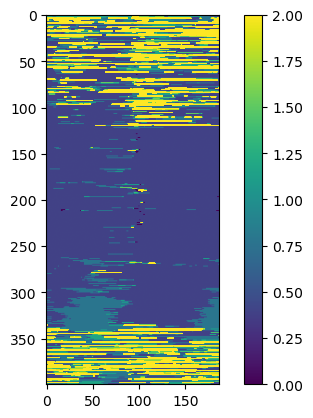

In [64]:
f,t,s = ss.spectrogram(backward,fs=50,axis=-1, nperseg=128,noverlap=126)
max_f_index = np.argmax(s,axis=1)
plt.imshow(f[max_f_index],vmax=2)
plt.colorbar()

In [18]:
1/2.25

0.4444444444444444

In [22]:
1/2.5*1015/2/2.25e6*1e6

90.22222222222223